# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

RANDOM_STATE = 101

plt.rcParams["figure.figsize"] = (8, 8)


# Load dataset

In [2]:
CSV_PATH = "files/train.csv"
TARGET = "SalePrice"

df = pd.read_csv(CSV_PATH)
df.head(20)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,534,531363010,20,RL,80.0,9605,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,159000
1,803,906203120,20,RL,90.0,14684,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,271900
2,956,916176030,20,RL,NaN,14375,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,1,2009,COD,Abnorml,137500
3,460,528180130,120,RL,48.0,6472,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,248500
4,487,528290030,80,RL,61.0,9734,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,167000
5,1965,535453150,20,RL,70.0,7315,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,140000
6,681,535452090,20,RL,71.0,7350,Pave,NaN,Reg,Lvl,...,0,NaN,GdWo,NaN,0,3,2009,WD,Normal,128000
7,1566,914467050,60,RL,NaN,11050,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,213000
8,419,527455240,20,RL,65.0,7150,Pave,NaN,Reg,Lvl,...,0,NaN,GdWo,NaN,0,7,2009,WD,Normal,100000
9,2346,527327080,60,RL,NaN,18800,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,190000


# Data exploration to see structure, statictics and correlations

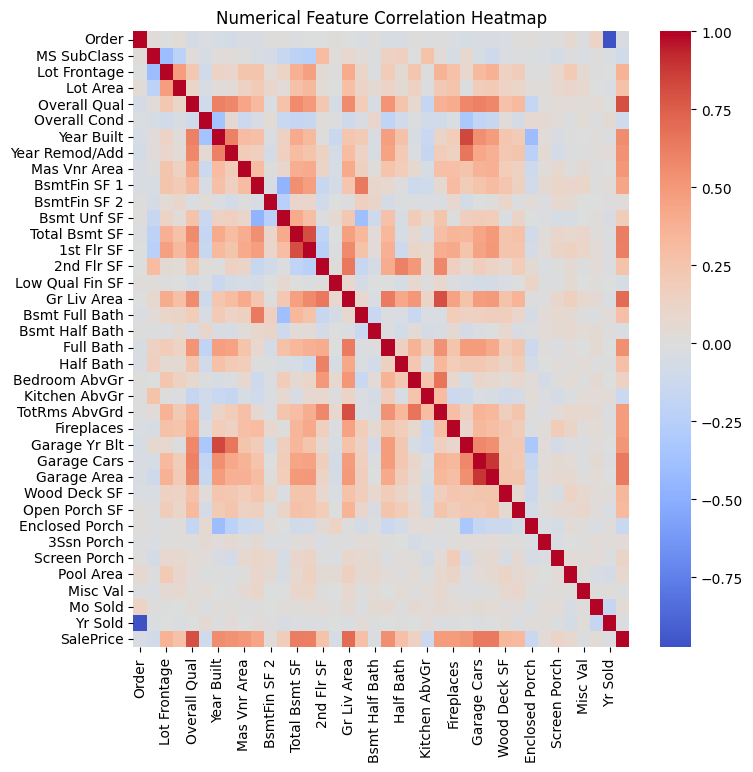

In [3]:
#df.info() # Display structure of the DataFrame
#display(df.describe().T.head(20)) # Display first 20 rows of statistical summary

if 'PID' in df.columns:
  df = df.drop(columns=["PID"])

num_corr = df.select_dtypes(include=np.number).corr(numeric_only=True)
sns.heatmap(num_corr, cmap="coolwarm", center=0)
plt.title("Numerical Feature Correlation Heatmap")
plt.show()


corr_target = num_corr[TARGET].dropna().sort_values(ascending=False)

# Identify top 5 features most correlated with the target variable
top_corr_features = corr_target.index.tolist()[1:6]

# Identify  bottom 5 features least correlated with the target variable
bottom_corr_features = corr_target.index.tolist()[-5:]

# Dispersion graphs of most correlated variables

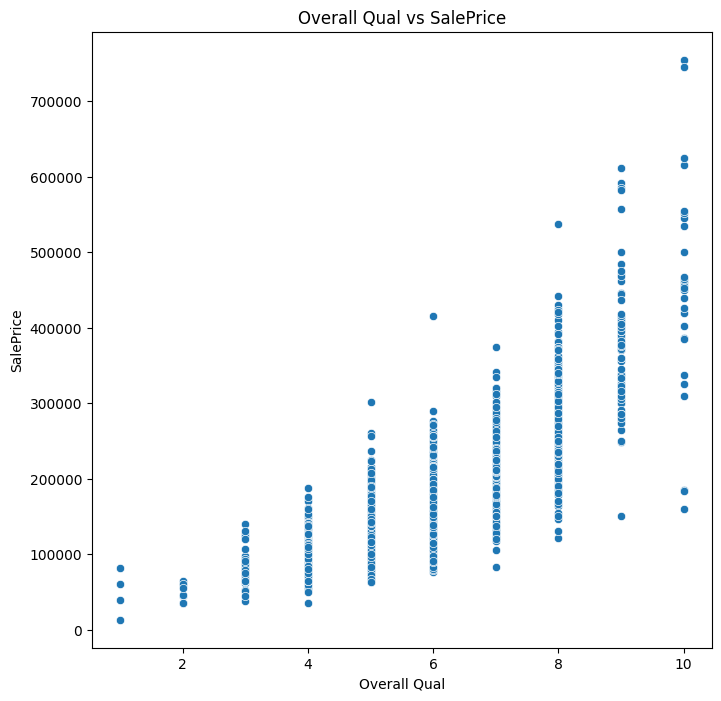

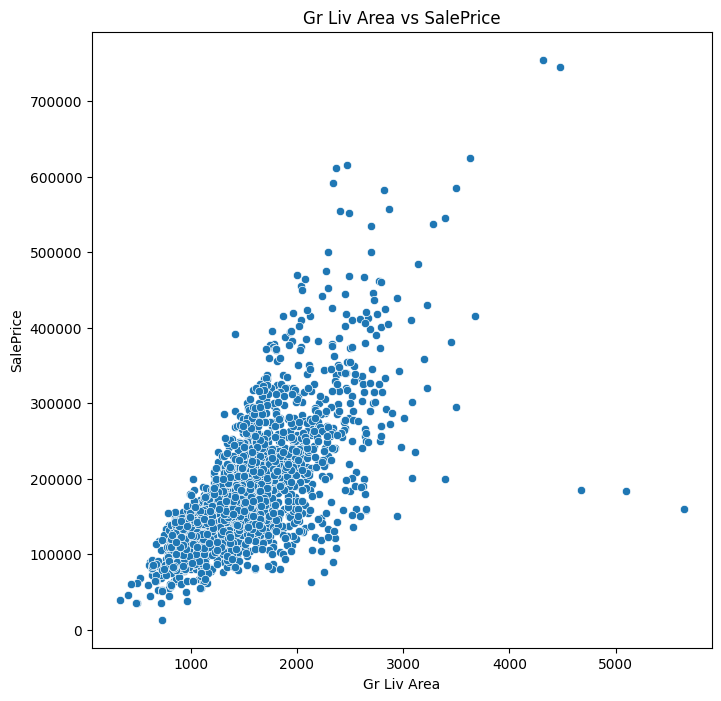

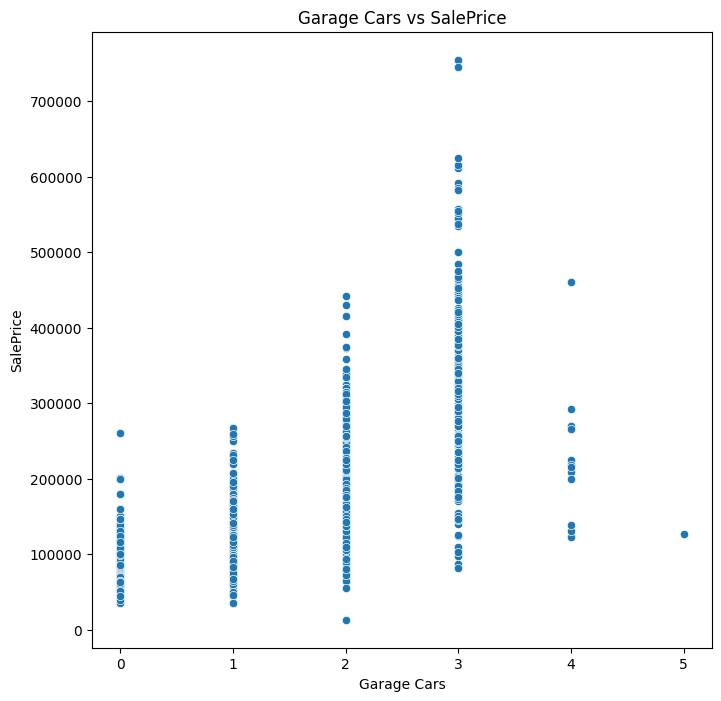

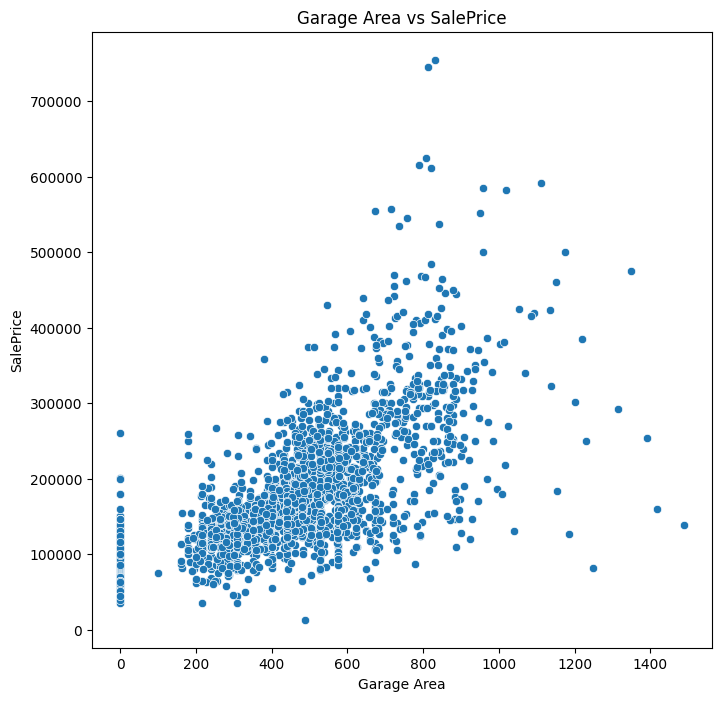

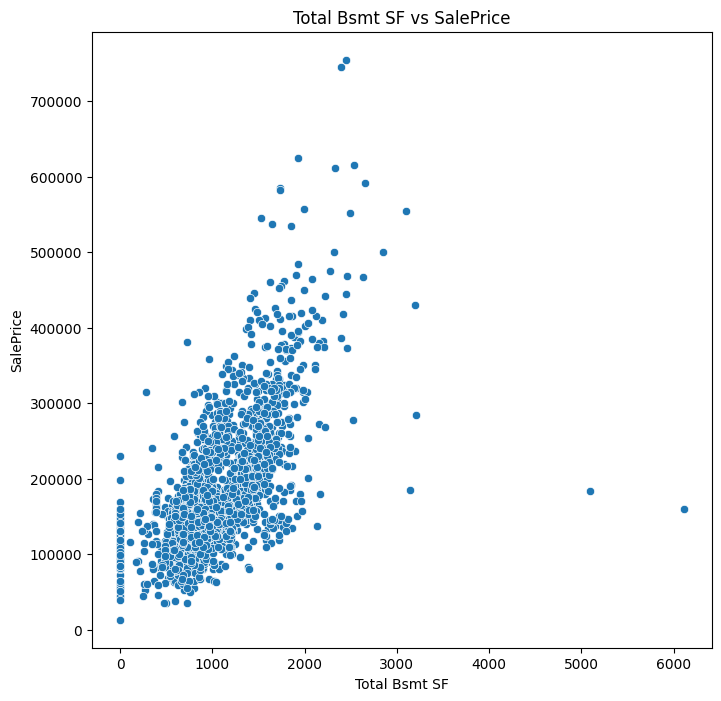

In [4]:
for col in top_corr_features:
    sns.scatterplot(data=df, x=col, y=TARGET)
    plt.title(f"{col} vs {TARGET}")
    plt.show()

# Dispersion graphs of less correlated variables

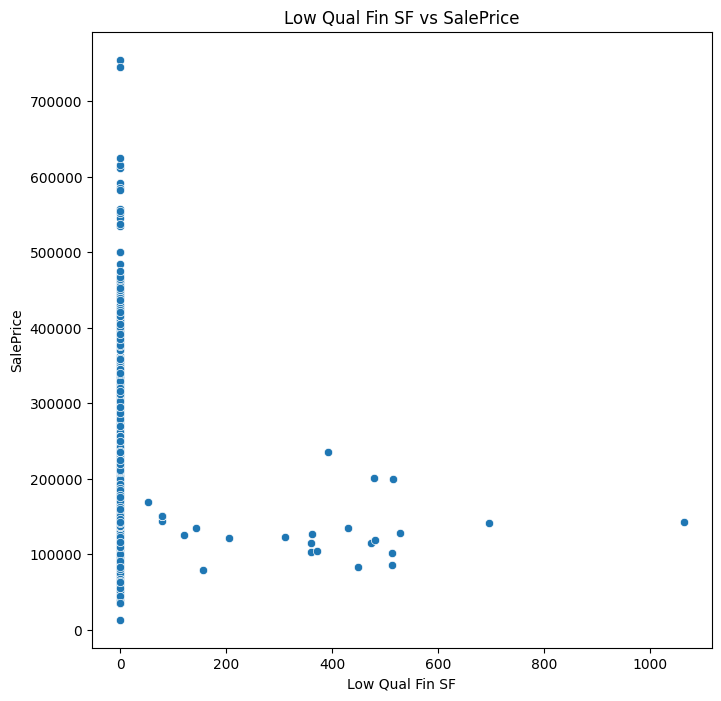

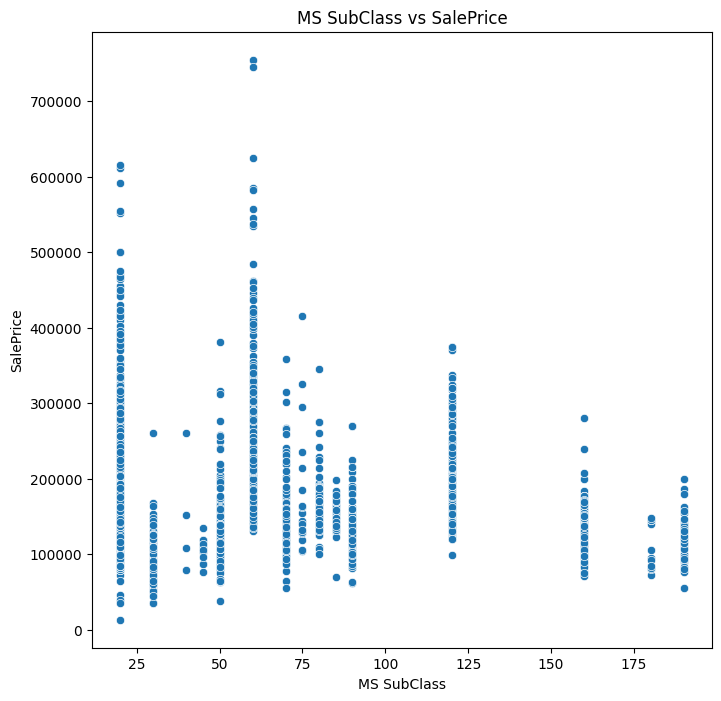

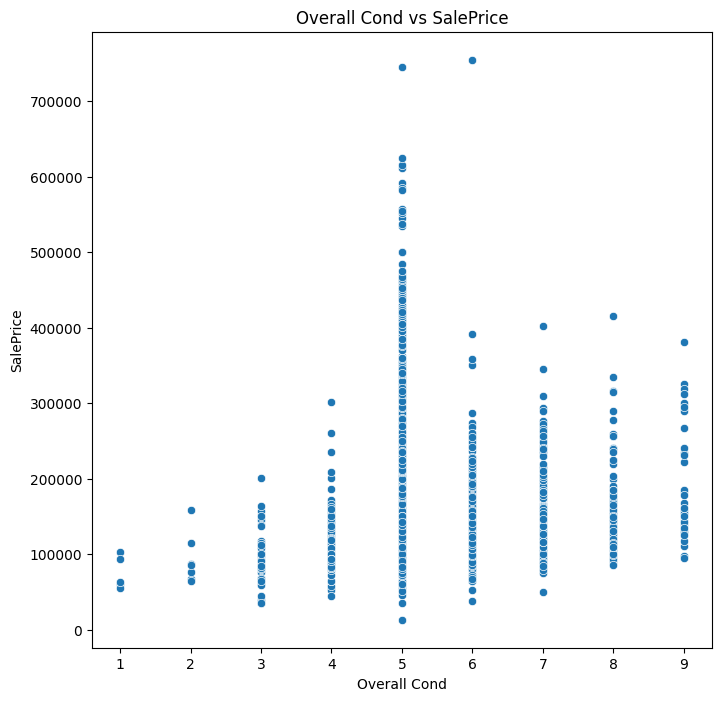

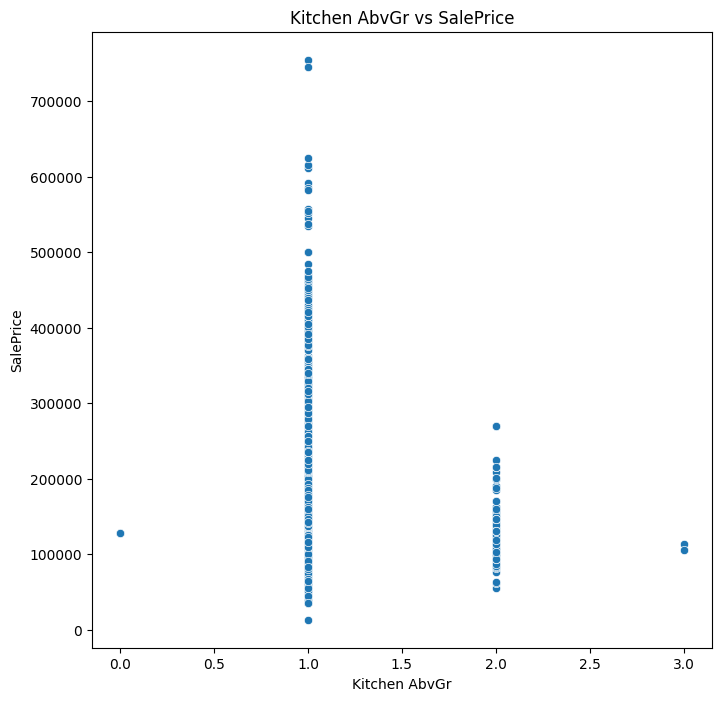

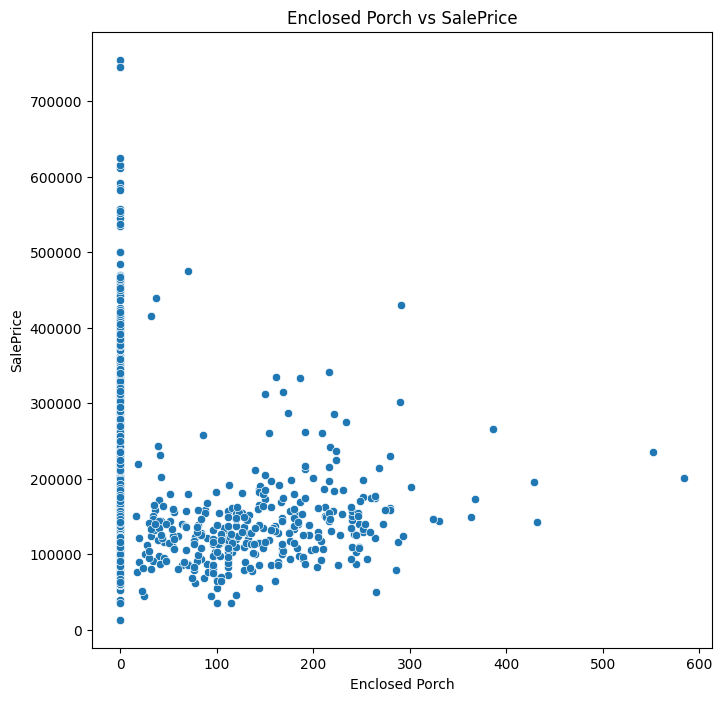

In [5]:
for col in bottom_corr_features:
    sns.scatterplot(data=df, x=col, y=TARGET)
    plt.title(f"{col} vs {TARGET}")
    plt.show()

# Elimination of outliers

In [6]:
def remove_outliers_iqr(df, cols, k=1.5):
    """Remove outliers from specified columns using the IQR method"""
    mask = pd.Series(True, index=df.index)
    for col in cols:
      if col not in df.columns or not np.issubdtype(df[col].dropna().dtype, np.number):
        continue
      q1 = df[col].quantile(0.25)
      q3 = df[col].quantile(0.75)
      iqr = q3 - q1
      lower_bound = q1 - k * iqr
      low, high = q1 - k*iqr, q3 + k*iqr
      mask &= df[col].between(lower_bound, high) | df[col].isna()
    return df[mask]

before = len(df)
df_filtered = remove_outliers_iqr(df, top_corr_features)
after = before - len(df_filtered)
ratio = after / before if before > 0 else 0

print(f"Removed {after} outliers from the dataset.")

if ratio > 0.12:
    print("Warning: More than 12% of data removed as outliers. Consider reviewing the outlier removal process.")
else:
    df = df_filtered
    print(f"Dataset size after outlier removal: {len(df)} rows.")

Removed 110 outliers from the dataset.
Dataset size after outlier removal: 2087 rows.


# Null Data 

In [7]:
null_percent = df.isnull().mean() * 100
display(null_percent[null_percent > 0].sort_values(ascending=False).head(15))

cols_to_drop = null_percent[null_percent > 50].index.tolist()
if cols_to_drop:
    df = df.drop(columns=cols_to_drop)
    print(f"Eliminated columns that have >50% null values: {cols_to_drop}")
else:
    print("No columns with >50% null values found.")


for c in df.select_dtypes(include=[np.number]).columns:
    if df[c].isnull().any():
        df[c] = df[c].fillna(df[c].median())

# Categóricas -> valor más frecuente
for col in df.select_dtypes(exclude=[np.number]).columns:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])

Pool QC          99.760422
Misc Feature     96.358409
Alley            93.387638
Fence            80.642070
Mas Vnr Type     61.954959
Fireplace Qu     50.311452
Lot Frontage     16.674653
Garage Qual       5.654049
Garage Cond       5.654049
Garage Yr Blt     5.654049
Garage Finish     5.654049
Garage Type       5.558218
Bsmt Exposure     3.114518
Bsmt Qual         3.018687
Bsmt Cond         3.018687
dtype: float64

Eliminated columns that have >50% null values: ['Alley', 'Mas Vnr Type', 'Fireplace Qu', 'Pool QC', 'Fence', 'Misc Feature']


# training validation split (90/10)

In [8]:
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=RANDOM_STATE
)

X_train.shape, X_val.shape

((1878, 74), (209, 74))

# Preprocessing

In [9]:
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

# Preprocessing pipelines for numerical and categorical data
num_pipeline = Pipeline([
  ("imputer", SimpleImputer(strategy="median")),
  ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
  ("imputer", SimpleImputer(strategy="most_frequent")),
  ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
  ("num", num_pipeline, num_cols),
  ("cat", cat_pipeline, cat_cols)
])

model = ElasticNet(max_iter=50000, random_state=RANDOM_STATE)

pipe = Pipeline([
  ("preprocessor", preprocessor),
  ("model", model)
])

# Hyperpamaters search

In [10]:
param_grid = {
  "model__alpha":[0.1, 1, 5, 10, 50, 100],
  "model__l1_ratio":[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0]
}

# Hyperparameter tuning with GridSearchCV
gridsearch = GridSearchCV(
  estimator=pipe,
  param_grid=param_grid,
  scoring="neg_mean_absolute_error",
  cv=5,
  n_jobs=-1,
)
gridsearch.fit(X_train, y_train)

print("Best Hyperparameters:", gridsearch.best_params_)
print("Best CV Score (neg_MSE):", gridsearch.best_score_)

best_model = gridsearch.best_estimator_

/home/coleexz/.local/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.470e+11, tolerance: 6.887e+08
  model = cd_fast.sparse_enet_coordinate_descent(
/home/coleexz/.local/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.680e+11, tolerance: 6.599e+08
  model = cd_fast.sparse_enet_coordinate_descent(
/home/coleexz/.local/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisatio

Best Hyperparameters: {'model__alpha': 50, 'model__l1_ratio': 1.0}
Best CV Score (neg_MSE): -13369.05252258188


# Model evaluation

In [11]:
y_pred = best_model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

print(f"Validation MAE: {mae:.2f}")
print(f"Validation MSE: {mse:.2f}")
print(f"Validation RMSE: {rmse:.2f}")

Validation MAE: 12669.84
Validation MSE: 303624070.30
Validation RMSE: 17424.81


# Result visualization

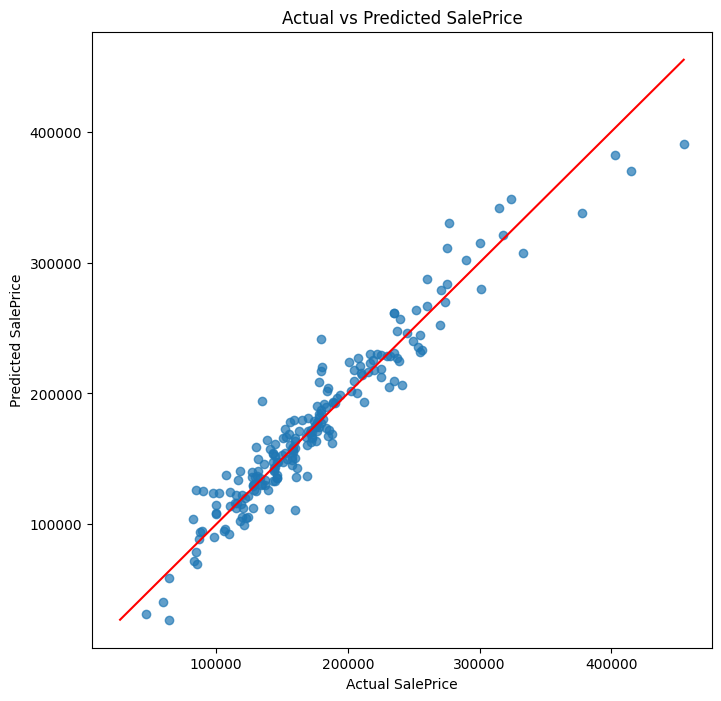

In [12]:
plt.figure()
plt.scatter(y_val, y_pred, alpha=0.7)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice")
lims = [min(y_val.min(), y_pred.min()), max(y_val.max(), y_pred.max())]
plt.plot(lims, lims, color="red")
plt.show()

# Save model

In [13]:
joblib.dump(best_model, "model/elasticnet_model.joblib")

pd.DataFrame({"y_true": y_val, "y_pred": y_pred}).to_csv("model/val_predictions.csv", index=False)
X_val_copy = X_val.copy()
X_val_copy[TARGET] = y_val
X_val_copy.to_csv("model/X_val_with_target.csv", index=False)